In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.signal import find_peaks
from tqdm import tqdm
from interleaver_parameters import *
from interleaver_2_stages import interleaver_2_stage_calc, calculate_spectrum_bandwidth
from interleaver_3_stages import interleaver_3_stage_calc

# Interleaver 2 stages

In [2]:
gf45clo_pdk_sin_neff_ng_variability = pd.read_csv("gf45clo_pdk_sin_neff_ng_variability.csv")
gf45clo_sin_neff_ng_variability = gf45clo_pdk_sin_neff_ng_variability[
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_width']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_height']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_sidewall_angle']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['wg_width (nm)']<1.5)
]

In [3]:
XPS_first_stage_loss_dB   = 0.07
XPS_second_stage_loss_dB  = 0.07
XPS_third_stage_loss_dB   = 0.07
SiN_propagation_loss_dB_m = 40
SiN_directional_coupler_loss_dB = 0.01

SiN_group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values)
SiN_effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values)
center_wavelength = 1310e-9
freq = c/(center_wavelength)
FSR_wavelength = 1600e9 * (center_wavelength)**2/(c)
channel_spacing = FSR_wavelength/8
channel1_wavelength = center_wavelength - 3.5*channel_spacing
channel2_wavelength = center_wavelength - 2.5*channel_spacing
channel3_wavelength = center_wavelength - 1.5*channel_spacing
channel4_wavelength = center_wavelength - 0.5*channel_spacing
channel5_wavelength = center_wavelength + 0.5*channel_spacing
channel6_wavelength = center_wavelength + 1.5*channel_spacing
channel7_wavelength = center_wavelength + 2.5*channel_spacing
channel8_wavelength = center_wavelength + 3.5*channel_spacing
channel_wavelength_array = [
    channel1_wavelength,
    channel2_wavelength,
    channel3_wavelength,
    channel4_wavelength,
    channel5_wavelength,
    channel6_wavelength,
    channel7_wavelength,
    channel8_wavelength,
]
dL_1600Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength)
dL_800Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength/2)
dL_400Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength/4)

optimization_wavelength_sweep = np.linspace(1295e-9,1325e-9,num=4000)
cost_function_plot_alpha = 0.3
bounds_epsilon = 5e-3

In [4]:
# Create compound effect of the three filter stages on top of each other
print("dL for 400Ghz FSR: ", dL_400Ghz_FSR)
um = 1e-6

interleaver_400Ghz_FSR = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = 0.5,
    dc2 = 0.63,
    dc3 = 0.9,
    
)
interleaver_400Ghz_FSR.channel_spacing = FSR_wavelength/8

interleaver_400Ghz_result = interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,bar_port_amp,cross_port_amp = interleaver_400Ghz_FSR.calculate_spectrum(*interleaver_400Ghz_result.x)

print("First stage insertion loss (dB): ", np.max(10*np.log10(bar_port_amp)))

dL for 400Ghz FSR:  0.00038810533884040785
  #      DC1        DC2        DC3       phi1      phi2       Cost
   0    0.500000    0.630000    0.900000    2.632727  2.036627  4274.492773
  10    0.501032    0.635000    0.898152    2.849453  1.916873  3587.958601
  20    0.499014    0.625303    0.900339    3.534481  1.599520  2025.021334
  30    0.495000    0.625000    0.905000    4.566749  1.207485  2046.984352
  40    0.496467    0.626133    0.904504    3.808770  1.486925  1741.410904
  50    0.496388    0.632875    0.901343    3.966658  1.979860  1387.835666
  60    0.496971    0.633400    0.900358    4.749757  2.266030  1342.102053
  70    0.497777    0.635000    0.899493    4.868062  2.958246  1275.569036
  80    0.497662    0.634917    0.898586    4.542122  2.629407  1083.444183
  90    0.498267    0.634934    0.897974    4.469422  2.623133  1072.523026
 100    0.497832    0.634908    0.898316    4.496103  2.619076  1075.029182
 110    0.498304    0.634915    0.898034    4.447543  

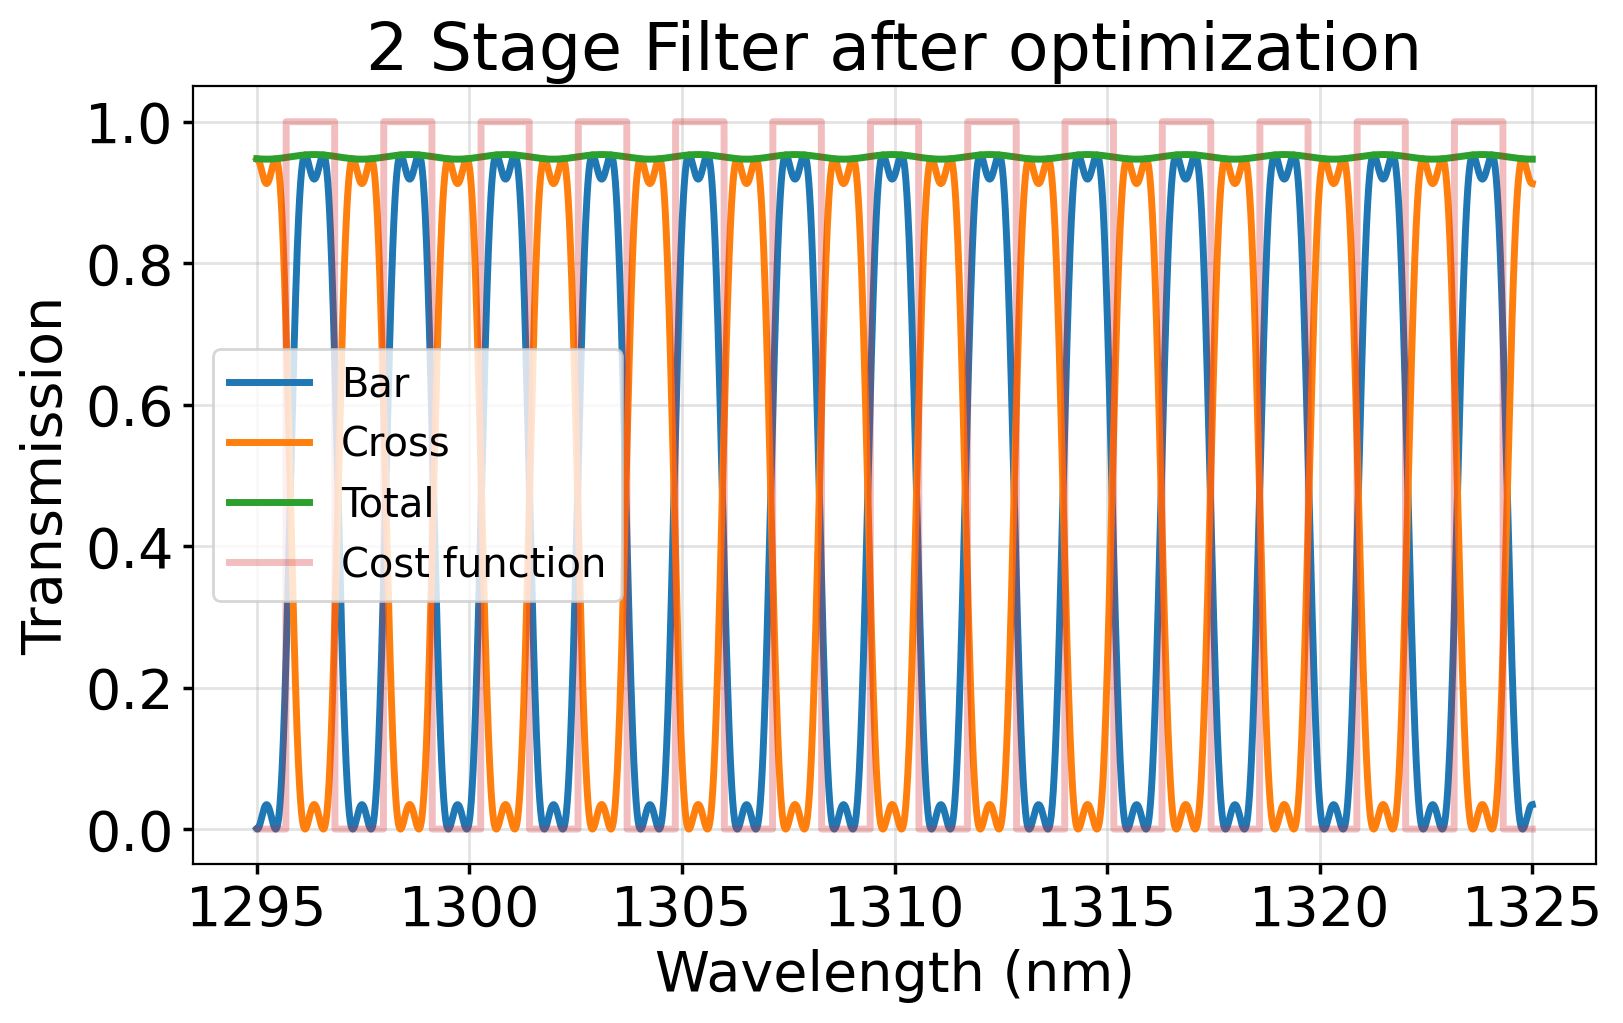

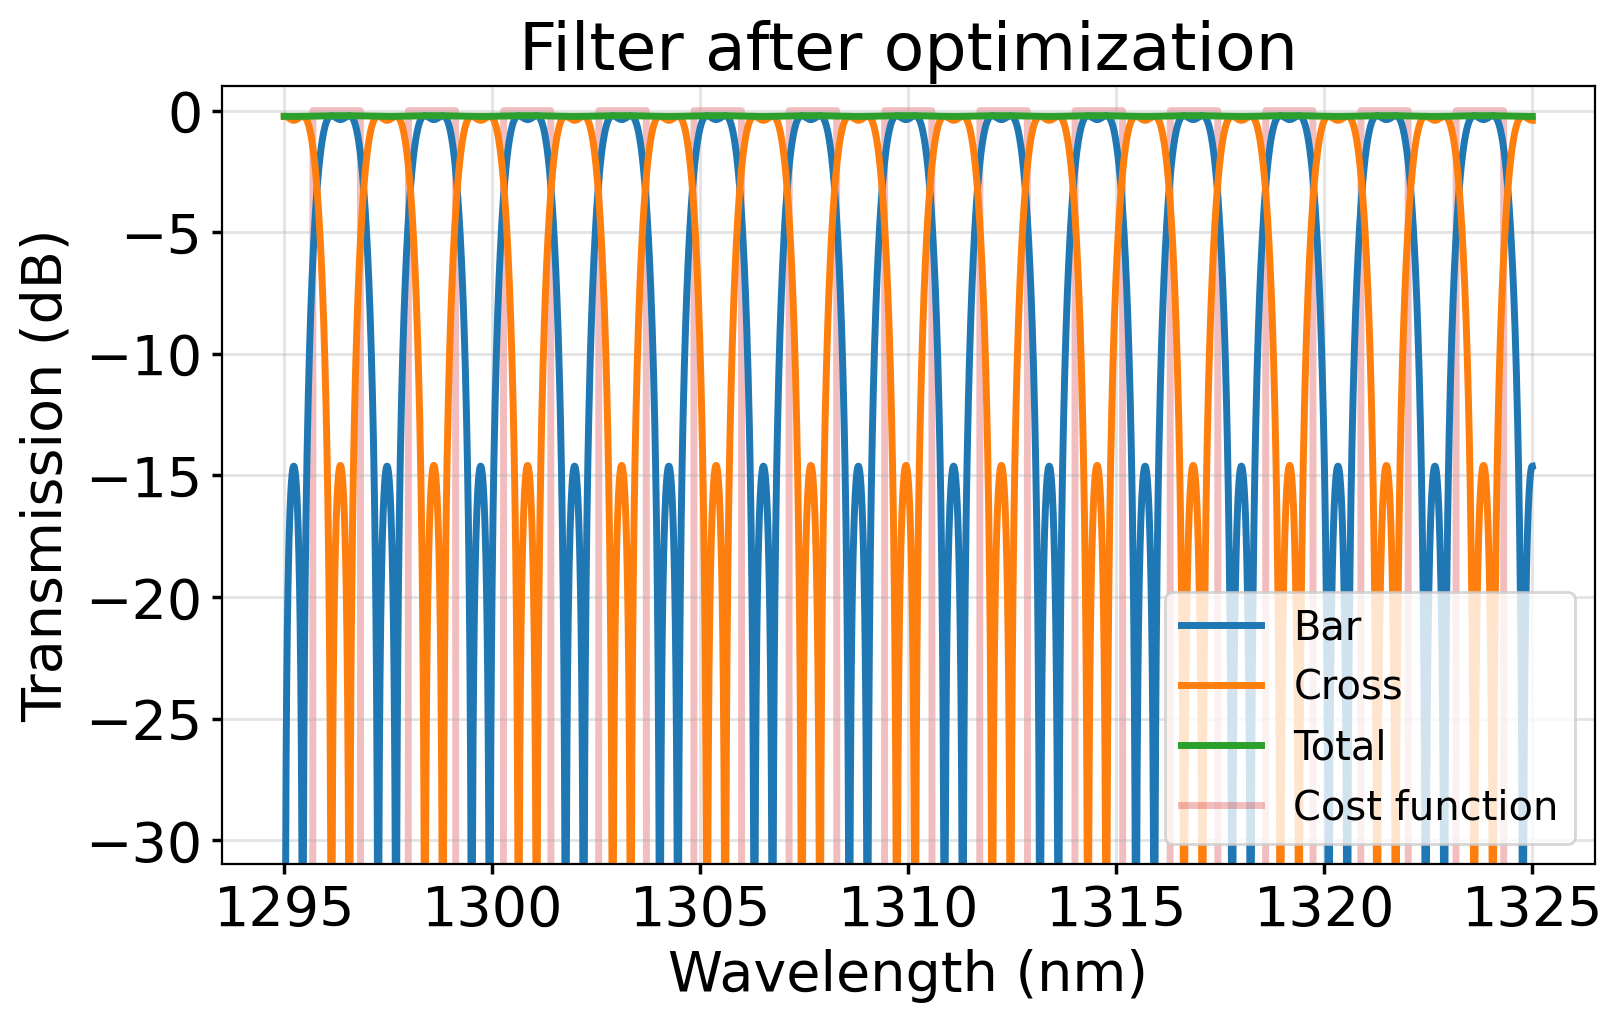

In [5]:
interleaver_400Ghz_FSR.plot_spectrum(interleaver_400Ghz_result)

In [6]:
random_variable_sigma = 0.02
rand_variable_dc1 = np.random.normal(0,random_variable_sigma) 

rand_dc1 = (1+rand_variable_dc1)*0.495
rand_dc2 = (1+rand_variable_dc1)*0.630
rand_dc3 = (1+rand_variable_dc1)*0.895

#Clamp values between 0 and 1
rand_dc1 = np.clip(rand_dc1,a_min=0,a_max=1)
rand_dc2 = np.clip(rand_dc2,a_min=0,a_max=1)
rand_dc3 = np.clip(rand_dc3,a_min=0,a_max=1)

new_dev_params = [
    rand_dc1,
    rand_dc2,
    rand_dc3,
    interleaver_400Ghz_result.x[3],
    interleaver_400Ghz_result.x[4],
]

In [7]:
median_group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values)
median_group_index_idd = np.argmin(np.abs(gf45clo_sin_neff_ng_variability['ng_freq0'].values-median_group_index))

median_ng_variation_interleaver = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = rand_dc1,
    dc2 = rand_dc2,
    dc3 = rand_dc3,
    effective_index = gf45clo_sin_neff_ng_variability['neff_freq0'].values[median_group_index_idd],
    group_index = gf45clo_sin_neff_ng_variability['ng_freq0'].values[median_group_index_idd]
)
median_ng_variation_interleaver.channel_spacing = FSR_wavelength/8

median_ng_variation_interleaver.phase_shift_1_top = interleaver_400Ghz_result.x[3]


new_dev_params = [
    rand_dc1,
    rand_dc2,
    rand_dc3,
    interleaver_400Ghz_result.x[3],
    interleaver_400Ghz_result.x[4],
]

wav,median_ng_bar_port_first_amp,median_ng_cross_port_amp = median_ng_variation_interleaver.calculate_spectrum(*new_dev_params)

In [8]:
min_group_index = np.min(gf45clo_sin_neff_ng_variability['ng_freq0'].values)
min_group_index_idd = np.argmin(np.abs(gf45clo_sin_neff_ng_variability['ng_freq0'].values-min_group_index))

min_ng_variation_interleaver = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = rand_dc1,
    dc2 = rand_dc2,
    dc3 = rand_dc3,
    effective_index = gf45clo_sin_neff_ng_variability['neff_freq0'].values[min_group_index_idd],
    group_index = gf45clo_sin_neff_ng_variability['ng_freq0'].values[min_group_index_idd]
)
min_ng_variation_interleaver.channel_spacing = FSR_wavelength/8

min_ng_variation_interleaver.phase_shift_1_top = interleaver_400Ghz_result.x[3]

wav,min_ng_bar_port_first_amp,min_ng_cross_port_amp = min_ng_variation_interleaver.calculate_spectrum(*new_dev_params)

In [9]:
max_group_index = np.max(gf45clo_sin_neff_ng_variability['ng_freq0'].values)
max_group_index_idd = np.argmin(np.abs(gf45clo_sin_neff_ng_variability['ng_freq0'].values-max_group_index))

max_ng_variation_interleaver = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = rand_dc1,
    dc2 = rand_dc2,
    dc3 = rand_dc3,
    effective_index = gf45clo_sin_neff_ng_variability['neff_freq0'].values[max_group_index_idd],
    group_index = gf45clo_sin_neff_ng_variability['ng_freq0'].values[max_group_index_idd]
)
max_ng_variation_interleaver.channel_spacing = FSR_wavelength/8

max_ng_variation_interleaver.phase_shift_1_top = interleaver_400Ghz_result.x[3]

wav,max_ng_bar_port_first_amp,max_ng_cross_port_amp = max_ng_variation_interleaver.calculate_spectrum(*new_dev_params)

(1300.0, 1320.0)

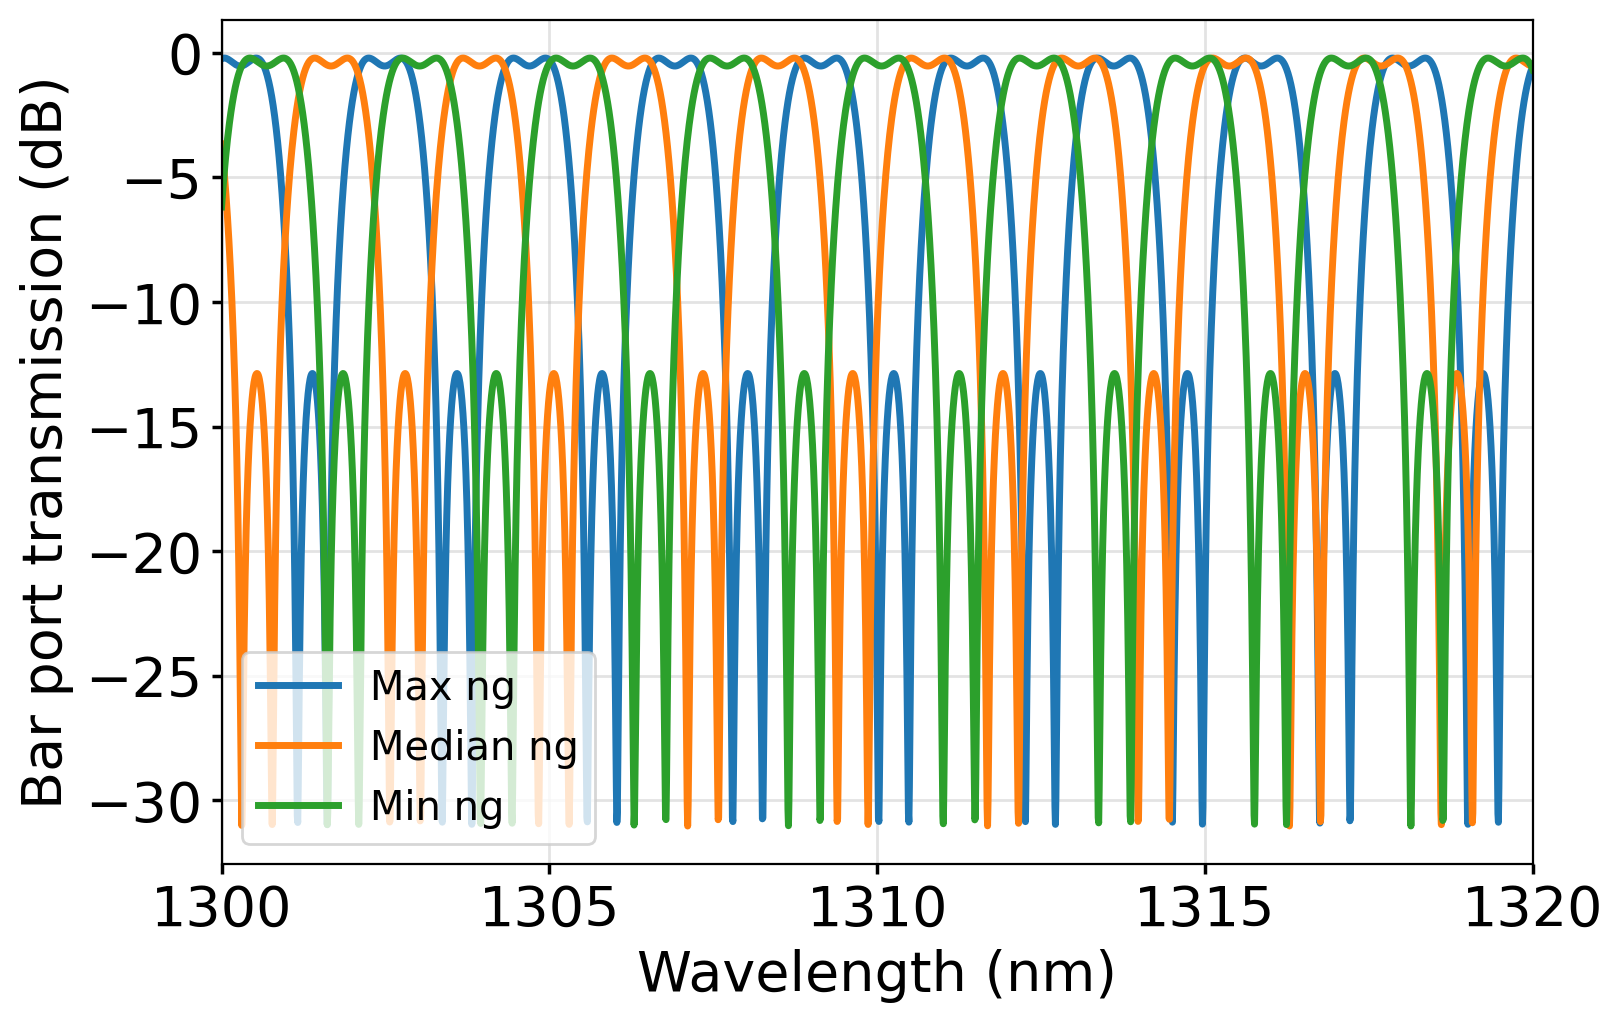

In [10]:
plt.plot(wav/1e-9, 10*np.log10(max_ng_bar_port_first_amp), label="Max ng")
plt.plot(wav/1e-9, 10*np.log10(median_ng_bar_port_first_amp), label="Median ng")
plt.plot(wav/1e-9, 10*np.log10(min_ng_bar_port_first_amp), label="Min ng")
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Bar port transmission (dB)")
plt.xlim([1300.0, 1320.0])

(-10.0, 0.0)

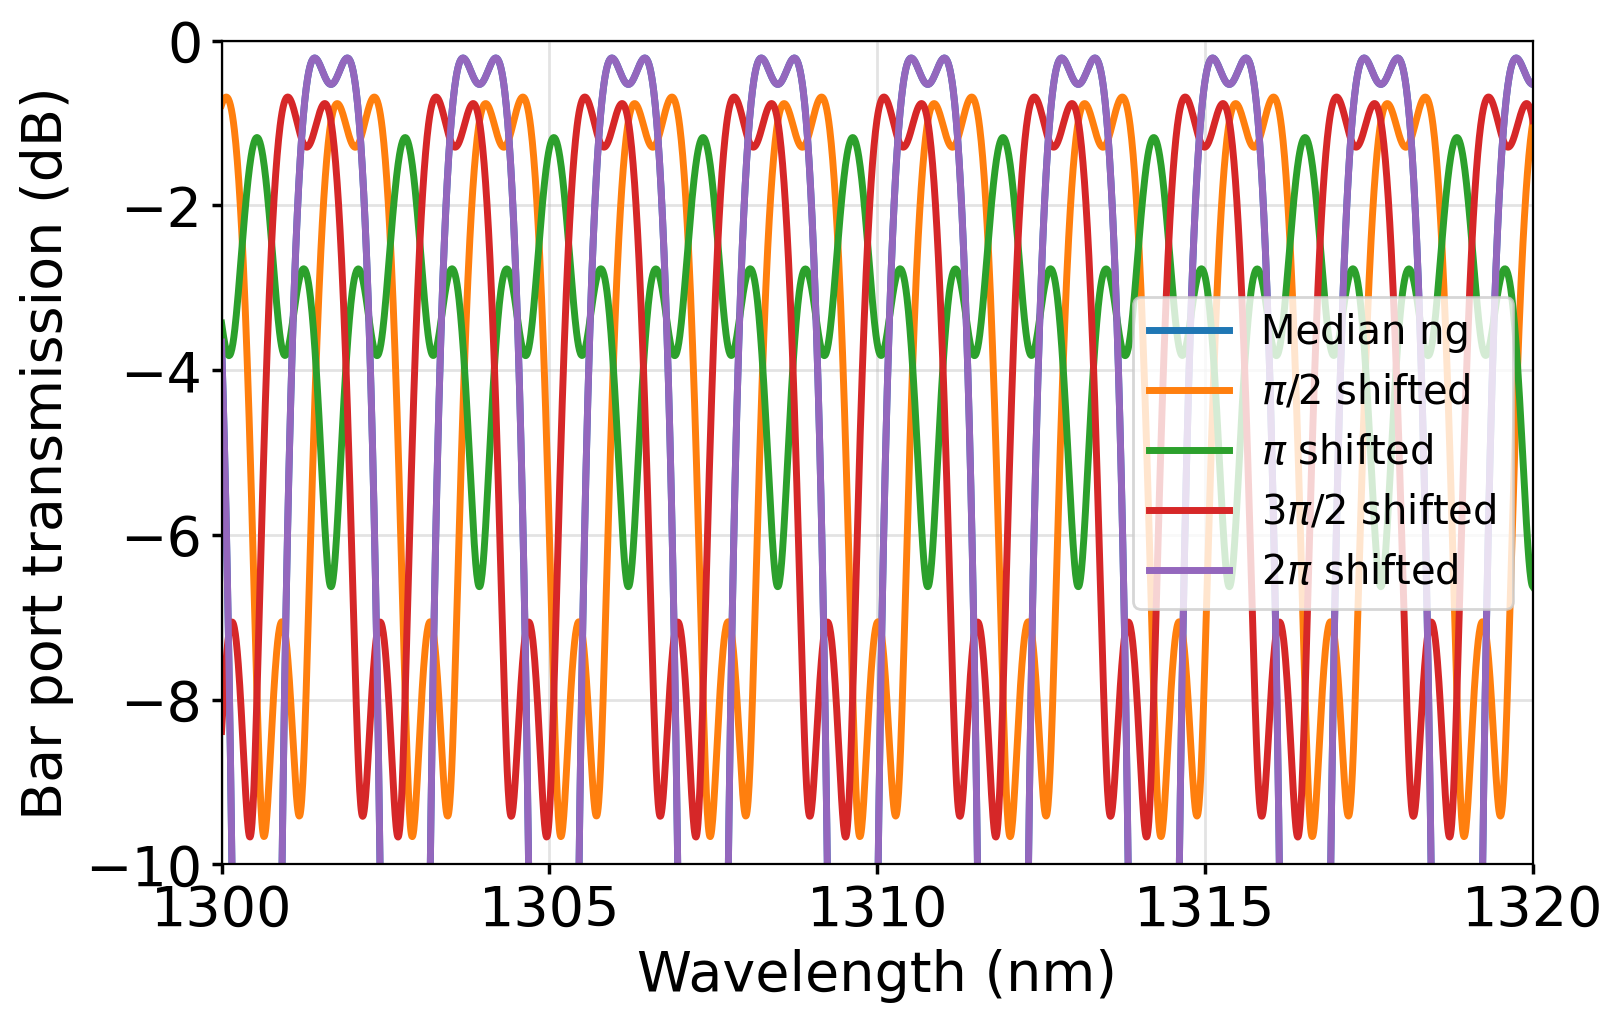

In [12]:
new_dev_params = [
    rand_dc1,
    rand_dc2,
    rand_dc3,
    interleaver_400Ghz_result.x[3] + np.pi/2,
    interleaver_400Ghz_result.x[4] + np.pi/2,
]

wav_shifted_pi_2,median_ng_bar_port_first_amp_shifted_pi_2,median_ng_cross_port_amp_shifted_pi_2 = median_ng_variation_interleaver.calculate_spectrum(*new_dev_params)

new_dev_params = [
    rand_dc1,
    rand_dc2,
    rand_dc3,
    interleaver_400Ghz_result.x[3] + 2*np.pi/2,
    interleaver_400Ghz_result.x[4] + 2*np.pi/2,
]

wav_shifted_pi,median_ng_bar_port_first_amp_shifted_pi,median_ng_cross_port_amp_shifted_pi = median_ng_variation_interleaver.calculate_spectrum(*new_dev_params)

new_dev_params = [
    rand_dc1,
    rand_dc2,
    rand_dc3,
    interleaver_400Ghz_result.x[3] + 3*np.pi/2,
    interleaver_400Ghz_result.x[4] + 3*np.pi/2,
]

wav_shifted_3pi_2,median_ng_bar_port_first_amp_shifted_3pi_2,median_ng_cross_port_amp_shifted_3pi_2 = median_ng_variation_interleaver.calculate_spectrum(*new_dev_params)

new_dev_params = [
    rand_dc1,
    rand_dc2,
    rand_dc3,
    interleaver_400Ghz_result.x[3] + 2*np.pi,
    interleaver_400Ghz_result.x[4] + 2*np.pi,
]

wav_shifted_2pi,median_ng_bar_port_first_amp_shifted_2pi,median_ng_cross_port_amp_shifted_2pi = median_ng_variation_interleaver.calculate_spectrum(*new_dev_params)

plt.plot(wav/1e-9, 10*np.log10(median_ng_bar_port_first_amp), label="Median ng")
plt.plot(wav_shifted_pi_2/1e-9, 10*np.log10(median_ng_bar_port_first_amp_shifted_pi_2), label=r"$\pi$/2 shifted")
plt.plot(wav_shifted_pi/1e-9, 10*np.log10(median_ng_bar_port_first_amp_shifted_pi), label=r"$\pi$ shifted")
plt.plot(wav_shifted_3pi_2/1e-9, 10*np.log10(median_ng_bar_port_first_amp_shifted_3pi_2), label=r"3$\pi$/2 shifted")
plt.plot(wav_shifted_2pi/1e-9, 10*np.log10(median_ng_bar_port_first_amp_shifted_2pi), label=r"2$\pi$ shifted")
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Bar port transmission (dB)")
plt.xlim([1300.0, 1320.0])
plt.ylim([-10, 0])

In [13]:
min_ng_interleaver_400Ghz_FSR = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = 0.5,
    dc2 = 0.63,
    dc3=0.9,
    effective_index=gf45clo_sin_neff_ng_variability['neff_freq0'].values[min_group_index_idd],
    group_index=gf45clo_sin_neff_ng_variability['ng_freq0'].values[min_group_index_idd]
)
min_ng_interleaver_400Ghz_FSR.channel_spacing = FSR_wavelength/8

min_ng_interleaver_400Ghz_result = min_ng_interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,min_ng_bar_port_amp_minimized,min_ng_cross_port_amp_minimized = min_ng_interleaver_400Ghz_FSR.calculate_spectrum(*min_ng_interleaver_400Ghz_result.x)

  #      DC1        DC2        DC3       phi1      phi2       Cost
   0    0.500000    0.630000    0.900000   -1.683647  2.782838  2061.239569
  10    0.495000    0.635000    0.905000   -1.796788  2.549080  1995.451772
  20    0.496928    0.631387    0.898076   -2.073654  2.109570  1950.782114
  30    0.495000    0.632448    0.896684   -2.166178  2.129696  1960.750117
  40    0.500152    0.631592    0.902175   -1.995855  2.241383  1949.304401
  50    0.498337    0.631473    0.904441   -2.031962  2.181859  1946.918769
  60    0.497488    0.631223    0.904882   -2.044046  2.187506  1946.521896
  70    0.497074    0.631741    0.904867   -2.057440  2.199698  1946.556675
  80    0.499177    0.631631    0.904947   -2.050277  2.181006  1946.206586
  90    0.502145    0.632200    0.904903   -2.044629  2.172268  1946.017701
 100    0.504888    0.633567    0.904898   -2.046855  2.178220  1945.451283
 110    0.505000    0.635000    0.904859   -2.044007  2.186403  1945.095975
 120    0.505000    0

In [14]:
max_ng_interleaver_400Ghz_FSR = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = 0.5,
    dc2 = 0.63,
    dc3=0.9,
    effective_index=gf45clo_sin_neff_ng_variability['neff_freq0'].values[max_group_index_idd],
    group_index=gf45clo_sin_neff_ng_variability['ng_freq0'].values[max_group_index_idd]
    
)
max_ng_interleaver_400Ghz_FSR.channel_spacing = FSR_wavelength/8

max_ng_interleaver_400Ghz_result = max_ng_interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,max_ng_bar_port_amp,max_ng_cross_port_amp = max_ng_interleaver_400Ghz_FSR.calculate_spectrum(*max_ng_interleaver_400Ghz_result.x)

  #      DC1        DC2        DC3       phi1      phi2       Cost
   0    0.500000    0.630000    0.900000    0.565407 -0.933909  2800.901520
  10    0.505000    0.625000    0.905000    0.562693 -0.855460  2712.459293
  20    0.504502    0.631130    0.903723    0.551455 -0.452180  2416.474572
  30    0.503903    0.635000    0.899164    0.421598  0.683423  1730.197945
  40    0.503391    0.634361    0.896450    0.389411  1.041939  1718.792280
  50    0.503263    0.635000    0.897646    0.442987  0.825137  1709.984604
  60    0.501948    0.635000    0.895753    0.516665  1.062002  1699.565832
  70    0.502346    0.634993    0.896009    0.506225  1.001167  1699.447568
  80    0.502311    0.634991    0.896220    0.499359  1.009470  1699.326955
  90    0.502223    0.634998    0.896303    0.504422  1.007523  1699.211861
 100    0.502089    0.634983    0.896439    0.510605  1.031701  1698.969201
 110    0.501936    0.634968    0.897067    0.524234  1.030885  1698.697495
 120    0.501837    0

(1300.0, 1320.0)

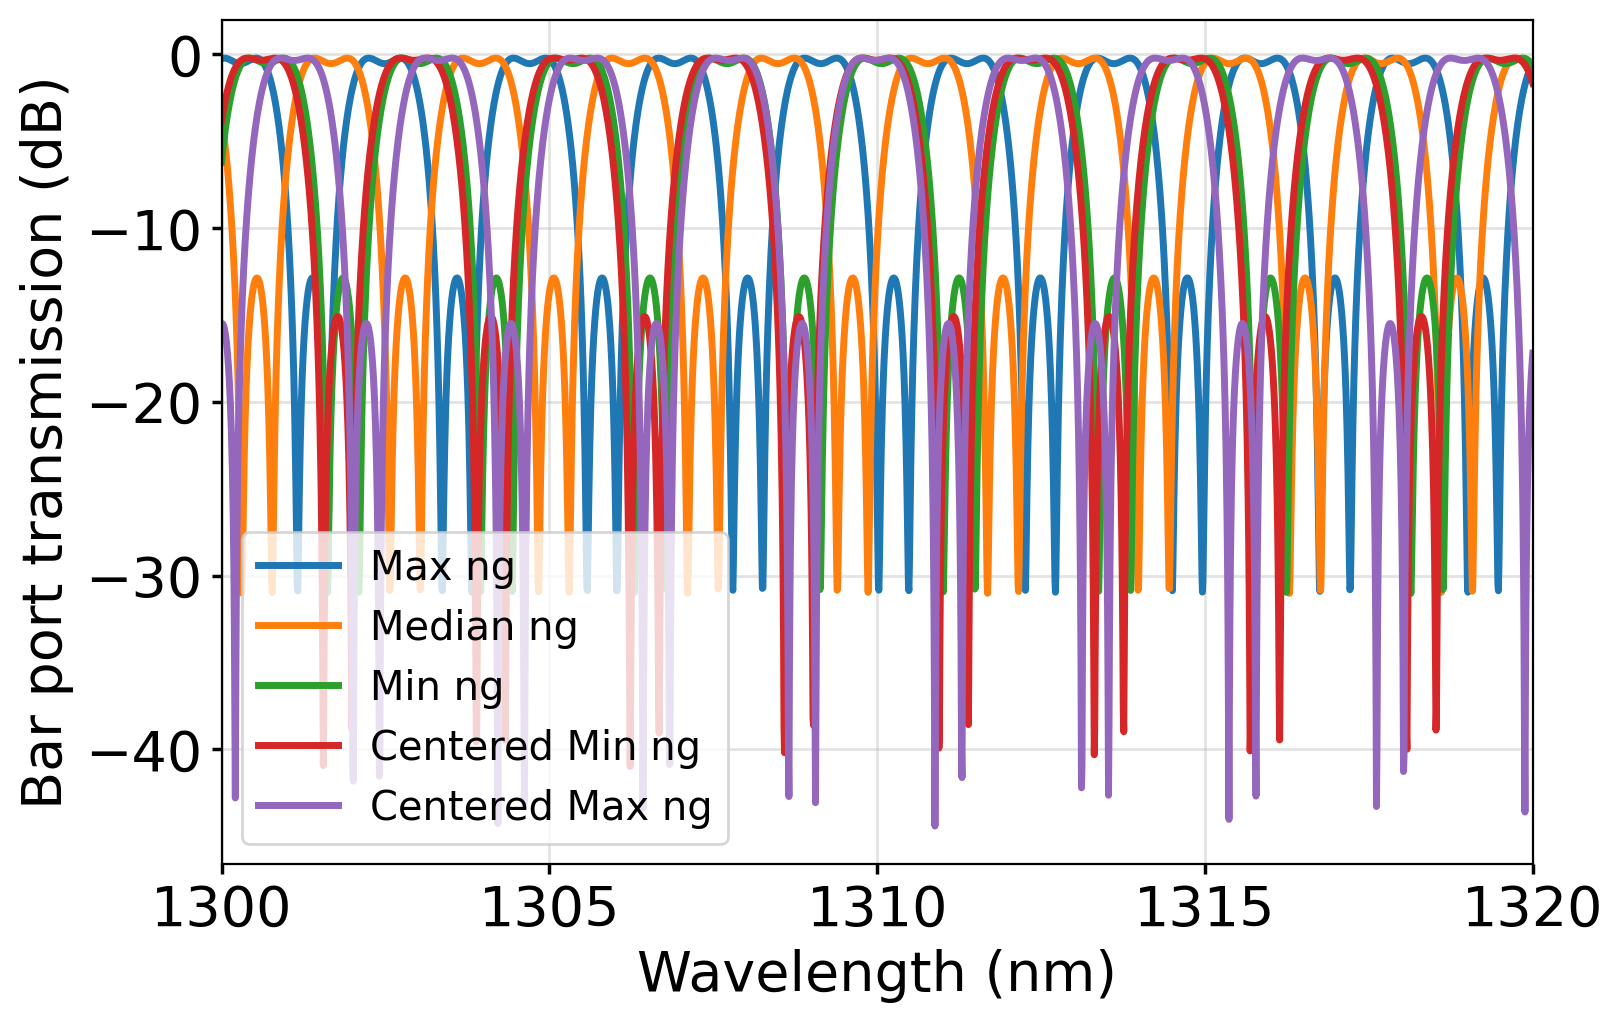

In [15]:
plt.plot(wav/1e-9, 10*np.log10(max_ng_bar_port_first_amp), label="Max ng")
plt.plot(wav/1e-9, 10*np.log10(median_ng_bar_port_first_amp), label="Median ng")
plt.plot(wav/1e-9, 10*np.log10(min_ng_bar_port_first_amp), label="Min ng")
plt.plot(wav/1e-9, 10*np.log10(min_ng_bar_port_amp_minimized), label="Centered Min ng")
plt.plot(wav/1e-9, 10*np.log10(max_ng_bar_port_amp), label="Centered Max ng")
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Bar port transmission (dB)")
plt.xlim([1300.0, 1320.0])
